In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


(1001, 2)
(1001, 1600, 2)
(1000, 1, 2) (1000, 1600, 2)
Total frames: 1000


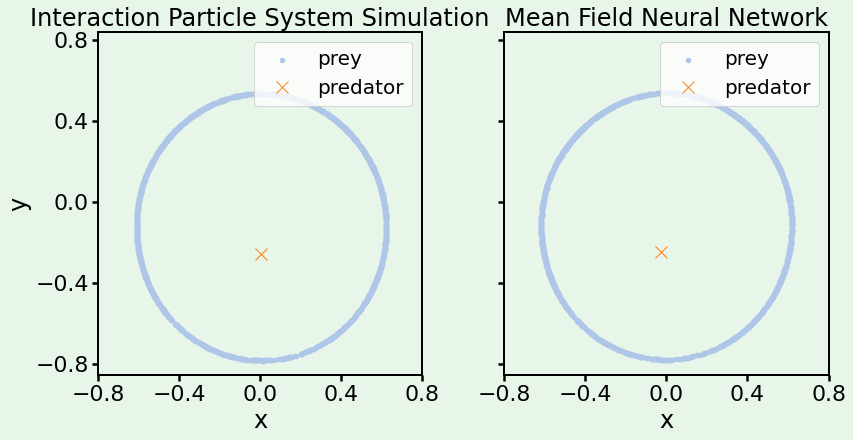

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.cm import tab20

# -----------------------------
# Load dataset A: (X, z)
# -----------------------------
dataA = np.load("../prey_predator2/TEST_DATA/data/swarm_data_101.npz")
XA = dataA["X"]       # shape ~ (T_A, N, 2)
zA = dataA["z"]
print(zA.shape)

# unify zA to (T_A, 2)
if zA.ndim == 3 and zA.shape[1] == 1:
    zA = zA[:, 0, :]
zA = zA.reshape(len(zA), 2)
print(XA.shape)

TA = int(min(len(XA), len(zA)))
if TA == 0:
    raise ValueError(f"Dataset A has no frames: len(XA)={len(XA)}, len(zA)={len(zA)}")

# -----------------------------
# Load dataset B: (data_x, data_z)
# -----------------------------
XB = np.load("../prey_predator2/SIM3/data_101/x_save_101.npy")   # (T_B, N, 2)
ZB = np.load("../prey_predator2/SIM3/data_101/z_save_101.npy")   # (T_B, M, 2)
ZB = ZB.reshape(len(ZB), -1, 2)
print(ZB.shape, XB.shape)

TB = len(ZB)
if TB == 0:
    raise ValueError(f"Dataset B has no frames: len(XB)={len(XB)}, len(ZB)={len(ZB)}")

# -----------------------------
# Use common frame count
# -----------------------------
T = min(TA, TB)
print("Total frames:", T)
if T == 1:
    print("Only one frame available across datasets; will save a static figure.")

# -----------------------------
# Axis limits (panel-specific)
# -----------------------------
xminA = float(np.nanmin(XA[:T, ..., 0]))
xmaxA = float(np.nanmax(XA[:T, ..., 0]))
yminA = float(np.nanmin(XA[:T, ..., 1]))
ymaxA = float(np.nanmax(XA[:T, ..., 1]))
xminA = min(xminA, float(np.nanmin(zA[:T, 0])))
xmaxA = max(xmaxA, float(np.nanmax(zA[:T, 0])))
yminA = min(yminA, float(np.nanmin(zA[:T, 1])))
ymaxA = max(ymaxA, float(np.nanmax(zA[:T, 1])))
padA = 0.05 * max(xmaxA - xminA, ymaxA - yminA, 1e-9)

xminB = float(np.nanmin([XB[:T, ..., 0].min(), ZB[:T, ..., 0].min()]))
xmaxB = float(np.nanmax([XB[:T, ..., 0].max(), ZB[:T, ..., 0].max()]))
yminB = float(np.nanmin([XB[:T, ..., 1].min(), ZB[:T, ..., 1].min()]))
ymaxB = float(np.nanmax([XB[:T, ..., 1].max(), ZB[:T, ..., 1].max()]))
padB = 0.05 * max(xmaxB - xminB, ymaxB - yminB, 1e-9)

# -----------------------------
# Figure setup (shared y-axis)
# -----------------------------
fig, (axA, axB) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True, sharey=True)
f_size = 24
bg_color = "#E8F5E9"    # 背景颜色（你指定的颜色）
fig.patch.set_facecolor(bg_color)
axA.set_facecolor(bg_color)
axB.set_facecolor(bg_color)
for ax in (axA, axB):
    ax.set_facecolor(bg_color)
    for side in ['right','left','top','bottom']:
        ax.spines[side].set_linewidth(2)
    ax.xaxis.set_tick_params(which='major', size=6, width=2.5, direction='out', top=False)
    ax.xaxis.set_tick_params(which='minor', size=3, width=2, direction='out', top=False)
    ax.yaxis.set_tick_params(which='major', size=6, width=2.5, direction='out', right=False)
    ax.yaxis.set_tick_params(which='minor', size=3, width=2, direction='out', right=False)

# Colors
c_agents = tab20(1)
c_target = tab20(2)

# --- Panel A ---
XA0 = XA[0].reshape(-1, 2)
zA0 = zA[0]
scatA = axA.scatter(XA0[:, 0], XA0[:, 1], s=20, color=c_agents, label="prey")
(targetA,) = axA.plot([zA0[0]], [zA0[1]], "x", color=c_target, markersize=12, label="predator")

axA.set_xlim(xminA - padA, xmaxA + padA)
axA.set_ylim(yminA - padA, ymaxA + padA)
axA.set_aspect("equal")
axA.set_title("Interaction Particle System Simulation", fontsize=f_size)
axA.legend(loc="upper right", fontsize=f_size - 4)

# --- Panel B ---
XB0 = XB[0].reshape(-1, 2)
ZB0 = ZB[0].reshape(-1, 2)
scatB = axB.scatter(XB0[:, 0], XB0[:, 1], s=20, color=c_agents, label="prey")
(targetsB,) = axB.plot(ZB0[:, 0], ZB0[:, 1], "x", color=c_target, markersize=12, linestyle="None", label="predator")

axB.set_xlim(xminB - padB, xmaxB + padB)
axB.set_ylim(yminB - padB, ymaxB + padB)
axB.set_aspect("equal")
axB.set_title("Mean Field Neural Network", fontsize=f_size)
axB.legend(loc="upper right", fontsize=f_size - 4)

# Shared tick style
for ax in (axA, axB):
    ax.tick_params(labelsize=f_size - 2, width=2.5, length=6, direction="out")
    ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_xlabel("x", fontsize=f_size)
axA.set_ylabel("y", fontsize=f_size)

time_text = fig.suptitle("t = 0.00", fontsize=f_size, y=0.98)
time_text.set_animated(True)   # <-- important when blitting
# -----------------------------
# Update function (sync both)
# -----------------------------
def update(frame):
    # Panel A
    XA_f = XA[frame].reshape(-1, 2)
    zA_f = zA[frame]
    scatA.set_offsets(XA_f)
    targetA.set_data([zA_f[0]], [zA_f[1]])

    # Panel B
    XB_f = XB[frame].reshape(-1, 2)
    ZB_f = ZB[frame].reshape(-1, 2)
    scatB.set_offsets(XB_f)
    targetsB.set_data(ZB_f[:, 0], ZB_f[:, 1])
    time_text.set_text("t = {:.2f}".format(1e-2*frame))
    return scatA, targetA, scatB, targetsB, time_text

# -----------------------------
# Animate & save MP4
# -----------------------------
if T == 1:
    plt.savefig("prey_predator_case_1_snapshot_1_static.png", dpi=150, bbox_inches="tight")
else:
    ani = FuncAnimation(fig, update, frames=T, blit=True, interval=100, cache_frame_data=False)
    writer = FFMpegWriter(fps=20, codec="h264", bitrate=2000)
    ani.save("prey_predator_case_1_snapshot_1_animation.mp4", writer=writer, dpi=150)

plt.show()


(1001, 2)
(1001, 1600, 2)
(1000, 1, 2) (1000, 1600, 2)
Total frames: 1000


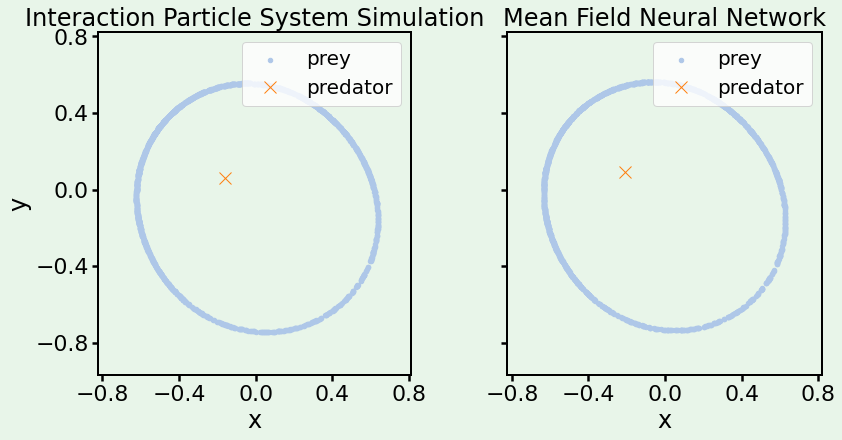

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.cm import tab20

# -----------------------------
# Load dataset A: (X, z)
# -----------------------------
dataA = np.load("../prey_predator2/TEST_DATA/data/swarm_data_102.npz")
XA = dataA["X"]       # shape ~ (T_A, N, 2)
zA = dataA["z"]
print(zA.shape)

# unify zA to (T_A, 2)
if zA.ndim == 3 and zA.shape[1] == 1:
    zA = zA[:, 0, :]
zA = zA.reshape(len(zA), 2)
print(XA.shape)

TA = int(min(len(XA), len(zA)))
if TA == 0:
    raise ValueError(f"Dataset A has no frames: len(XA)={len(XA)}, len(zA)={len(zA)}")

# -----------------------------
# Load dataset B: (data_x, data_z)
# -----------------------------
XB = np.load("../prey_predator2/SIM3/data_102/x_save_102.npy")   # (T_B, N, 2)
ZB = np.load("../prey_predator2/SIM3/data_102/z_save_102.npy")   # (T_B, M, 2)
ZB = ZB.reshape(len(ZB), -1, 2)
print(ZB.shape, XB.shape)

TB = len(ZB)
if TB == 0:
    raise ValueError(f"Dataset B has no frames: len(XB)={len(XB)}, len(ZB)={len(ZB)}")

# -----------------------------
# Use common frame count
# -----------------------------
T = min(TA, TB)
print("Total frames:", T)
if T == 1:
    print("Only one frame available across datasets; will save a static figure.")

# -----------------------------
# Axis limits (panel-specific)
# -----------------------------
xminA = float(np.nanmin(XA[:T, ..., 0]))
xmaxA = float(np.nanmax(XA[:T, ..., 0]))
yminA = float(np.nanmin(XA[:T, ..., 1]))
ymaxA = float(np.nanmax(XA[:T, ..., 1]))
xminA = min(xminA, float(np.nanmin(zA[:T, 0])))
xmaxA = max(xmaxA, float(np.nanmax(zA[:T, 0])))
yminA = min(yminA, float(np.nanmin(zA[:T, 1])))
ymaxA = max(ymaxA, float(np.nanmax(zA[:T, 1])))
padA = 0.05 * max(xmaxA - xminA, ymaxA - yminA, 1e-9)

xminB = float(np.nanmin([XB[:T, ..., 0].min(), ZB[:T, ..., 0].min()]))
xmaxB = float(np.nanmax([XB[:T, ..., 0].max(), ZB[:T, ..., 0].max()]))
yminB = float(np.nanmin([XB[:T, ..., 1].min(), ZB[:T, ..., 1].min()]))
ymaxB = float(np.nanmax([XB[:T, ..., 1].max(), ZB[:T, ..., 1].max()]))
padB = 0.05 * max(xmaxB - xminB, ymaxB - yminB, 1e-9)

# -----------------------------
# Figure setup (shared y-axis)
# -----------------------------
fig, (axA, axB) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True, sharey=True)
f_size = 24
bg_color = "#E8F5E9"    # 背景颜色（你指定的颜色）
fig.patch.set_facecolor(bg_color)
axA.set_facecolor(bg_color)
axB.set_facecolor(bg_color)
for ax in (axA, axB):
    ax.set_facecolor(bg_color)
    for side in ['right','left','top','bottom']:
        ax.spines[side].set_linewidth(2)
    ax.xaxis.set_tick_params(which='major', size=6, width=2.5, direction='out', top=False)
    ax.xaxis.set_tick_params(which='minor', size=3, width=2, direction='out', top=False)
    ax.yaxis.set_tick_params(which='major', size=6, width=2.5, direction='out', right=False)
    ax.yaxis.set_tick_params(which='minor', size=3, width=2, direction='out', right=False)

# Colors
c_agents = tab20(1)
c_target = tab20(2)

# --- Panel A ---
XA0 = XA[0].reshape(-1, 2)
zA0 = zA[0]
scatA = axA.scatter(XA0[:, 0], XA0[:, 1], s=20, color=c_agents, label="prey")
(targetA,) = axA.plot([zA0[0]], [zA0[1]], "x", color=c_target, markersize=12, label="predator")

axA.set_xlim(xminA - padA, xmaxA + padA)
axA.set_ylim(yminA - padA, ymaxA + padA)
axA.set_aspect("equal")
axA.set_title("Interaction Particle System Simulation", fontsize=f_size)
axA.legend(loc="upper right", fontsize=f_size - 4)

# --- Panel B ---
XB0 = XB[0].reshape(-1, 2)
ZB0 = ZB[0].reshape(-1, 2)
scatB = axB.scatter(XB0[:, 0], XB0[:, 1], s=20, color=c_agents, label="prey")
(targetsB,) = axB.plot(ZB0[:, 0], ZB0[:, 1], "x", color=c_target, markersize=12, linestyle="None", label="predator")

axB.set_xlim(xminB - padB, xmaxB + padB)
axB.set_ylim(yminB - padB, ymaxB + padB)
axB.set_aspect("equal")
axB.set_title("Mean Field Neural Network", fontsize=f_size)
axB.legend(loc="upper right", fontsize=f_size - 4)

# Shared tick style
for ax in (axA, axB):
    ax.tick_params(labelsize=f_size - 2, width=2.5, length=6, direction="out")
    ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_xlabel("x", fontsize=f_size)
axA.set_ylabel("y", fontsize=f_size)

time_text = fig.suptitle("t = 0.00", fontsize=f_size, y=0.98)
time_text.set_animated(True)   # <-- important when blitting
# -----------------------------
# Update function (sync both)
# -----------------------------
def update(frame):
    # Panel A
    XA_f = XA[frame].reshape(-1, 2)
    zA_f = zA[frame]
    scatA.set_offsets(XA_f)
    targetA.set_data([zA_f[0]], [zA_f[1]])

    # Panel B
    XB_f = XB[frame].reshape(-1, 2)
    ZB_f = ZB[frame].reshape(-1, 2)
    scatB.set_offsets(XB_f)
    targetsB.set_data(ZB_f[:, 0], ZB_f[:, 1])
    time_text.set_text("t = {:.2f}".format(1e-2*frame))
    return scatA, targetA, scatB, targetsB, time_text

# -----------------------------
# Animate & save MP4
# -----------------------------
if T == 1:
    plt.savefig("prey_predator_case_1_snapshot_2_static.png", dpi=150, bbox_inches="tight")
else:
    ani = FuncAnimation(fig, update, frames=T, blit=True, interval=100, cache_frame_data=False)
    writer = FFMpegWriter(fps=20, codec="h264", bitrate=2000)
    ani.save("prey_predator_case_1_snapshot_2_animation.mp4", writer=writer, dpi=150)

plt.show()


(1001, 2)
(1001, 1600, 2)
(1000, 1, 2) (1000, 1600, 2)
Total frames: 1000


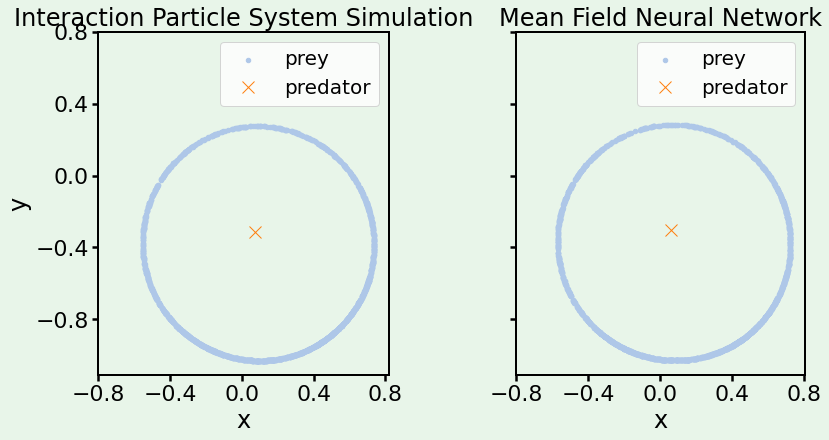

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.cm import tab20

# -----------------------------
# Load dataset A: (X, z)
# -----------------------------
dataA = np.load("../prey_predator2/TEST_DATA2/data/swarm_data_101.npz")
XA = dataA["X"]       # shape ~ (T_A, N, 2)
zA = dataA["z"]
print(zA.shape)

# unify zA to (T_A, 2)
if zA.ndim == 3 and zA.shape[1] == 1:
    zA = zA[:, 0, :]
zA = zA.reshape(len(zA), 2)
print(XA.shape)

TA = int(min(len(XA), len(zA)))
if TA == 0:
    raise ValueError(f"Dataset A has no frames: len(XA)={len(XA)}, len(zA)={len(zA)}")

# -----------------------------
# Load dataset B: (data_x, data_z)
# -----------------------------
XB = np.load("../prey_predator2/SIM3_2/data_101/x_save_101.npy")   # (T_B, N, 2)
ZB = np.load("../prey_predator2/SIM3_2/data_101/z_save_101.npy")   # (T_B, M, 2)
ZB = ZB.reshape(len(ZB), -1, 2)
print(ZB.shape, XB.shape)

TB = len(ZB)
if TB == 0:
    raise ValueError(f"Dataset B has no frames: len(XB)={len(XB)}, len(ZB)={len(ZB)}")

# -----------------------------
# Use common frame count
# -----------------------------
T = min(TA, TB)
print("Total frames:", T)
if T == 1:
    print("Only one frame available across datasets; will save a static figure.")

# -----------------------------
# Axis limits (panel-specific)
# -----------------------------
xminA = float(np.nanmin(XA[:T, ..., 0]))
xmaxA = float(np.nanmax(XA[:T, ..., 0]))
yminA = float(np.nanmin(XA[:T, ..., 1]))
ymaxA = float(np.nanmax(XA[:T, ..., 1]))
xminA = min(xminA, float(np.nanmin(zA[:T, 0])))
xmaxA = max(xmaxA, float(np.nanmax(zA[:T, 0])))
yminA = min(yminA, float(np.nanmin(zA[:T, 1])))
ymaxA = max(ymaxA, float(np.nanmax(zA[:T, 1])))
padA = 0.05 * max(xmaxA - xminA, ymaxA - yminA, 1e-9)

xminB = float(np.nanmin([XB[:T, ..., 0].min(), ZB[:T, ..., 0].min()]))
xmaxB = float(np.nanmax([XB[:T, ..., 0].max(), ZB[:T, ..., 0].max()]))
yminB = float(np.nanmin([XB[:T, ..., 1].min(), ZB[:T, ..., 1].min()]))
ymaxB = float(np.nanmax([XB[:T, ..., 1].max(), ZB[:T, ..., 1].max()]))
padB = 0.05 * max(xmaxB - xminB, ymaxB - yminB, 1e-9)

# -----------------------------
# Figure setup (shared y-axis)
# -----------------------------
fig, (axA, axB) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True, sharey=True)
f_size = 24
bg_color = "#E8F5E9"    # 背景颜色（你指定的颜色）
fig.patch.set_facecolor(bg_color)
axA.set_facecolor(bg_color)
axB.set_facecolor(bg_color)
for ax in (axA, axB):
    ax.set_facecolor(bg_color)
    for side in ['right','left','top','bottom']:
        ax.spines[side].set_linewidth(2)
    ax.xaxis.set_tick_params(which='major', size=6, width=2.5, direction='out', top=False)
    ax.xaxis.set_tick_params(which='minor', size=3, width=2, direction='out', top=False)
    ax.yaxis.set_tick_params(which='major', size=6, width=2.5, direction='out', right=False)
    ax.yaxis.set_tick_params(which='minor', size=3, width=2, direction='out', right=False)

# Colors
c_agents = tab20(1)
c_target = tab20(2)

# --- Panel A ---
XA0 = XA[0].reshape(-1, 2)
zA0 = zA[0]
scatA = axA.scatter(XA0[:, 0], XA0[:, 1], s=20, color=c_agents, label="prey")
(targetA,) = axA.plot([zA0[0]], [zA0[1]], "x", color=c_target, markersize=12, label="predator")

axA.set_xlim(xminA - padA, xmaxA + padA)
axA.set_ylim(yminA - padA, ymaxA + padA)
axA.set_aspect("equal")
axA.set_title("Interaction Particle System Simulation", fontsize=f_size)
axA.legend(loc="upper right", fontsize=f_size - 4)

# --- Panel B ---
XB0 = XB[0].reshape(-1, 2)
ZB0 = ZB[0].reshape(-1, 2)
scatB = axB.scatter(XB0[:, 0], XB0[:, 1], s=20, color=c_agents, label="prey")
(targetsB,) = axB.plot(ZB0[:, 0], ZB0[:, 1], "x", color=c_target, markersize=12, linestyle="None", label="predator")

axB.set_xlim(xminB - padB, xmaxB + padB)
axB.set_ylim(yminB - padB, ymaxB + padB)
axB.set_aspect("equal")
axB.set_title("Mean Field Neural Network", fontsize=f_size)
axB.legend(loc="upper right", fontsize=f_size - 4)

# Shared tick style
for ax in (axA, axB):
    ax.tick_params(labelsize=f_size - 2, width=2.5, length=6, direction="out")
    ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_xlabel("x", fontsize=f_size)
axA.set_ylabel("y", fontsize=f_size)

time_text = fig.suptitle("t = 0.00", fontsize=f_size, y=0.98)
time_text.set_animated(True)   # <-- important when blitting
# -----------------------------
# Update function (sync both)
# -----------------------------
def update(frame):
    # Panel A
    XA_f = XA[frame].reshape(-1, 2)
    zA_f = zA[frame]
    scatA.set_offsets(XA_f)
    targetA.set_data([zA_f[0]], [zA_f[1]])

    # Panel B
    XB_f = XB[frame].reshape(-1, 2)
    ZB_f = ZB[frame].reshape(-1, 2)
    scatB.set_offsets(XB_f)
    targetsB.set_data(ZB_f[:, 0], ZB_f[:, 1])
    time_text.set_text("t = {:.2f}".format(1e-2*frame))
    return scatA, targetA, scatB, targetsB, time_text

# -----------------------------
# Animate & save MP4
# -----------------------------
if T == 1:
    plt.savefig("prey_predator_case_2_snapshot_1_static.png", dpi=150, bbox_inches="tight")
else:
    ani = FuncAnimation(fig, update, frames=T, blit=True, interval=100, cache_frame_data=False)
    writer = FFMpegWriter(fps=20, codec="h264", bitrate=2000)
    ani.save("prey_predator_case_2_snapshot_1_animation.mp4", writer=writer, dpi=150)

plt.show()


(1001, 2)
(1001, 1600, 2)
(1000, 1, 2) (1000, 1600, 2)
Total frames: 1000


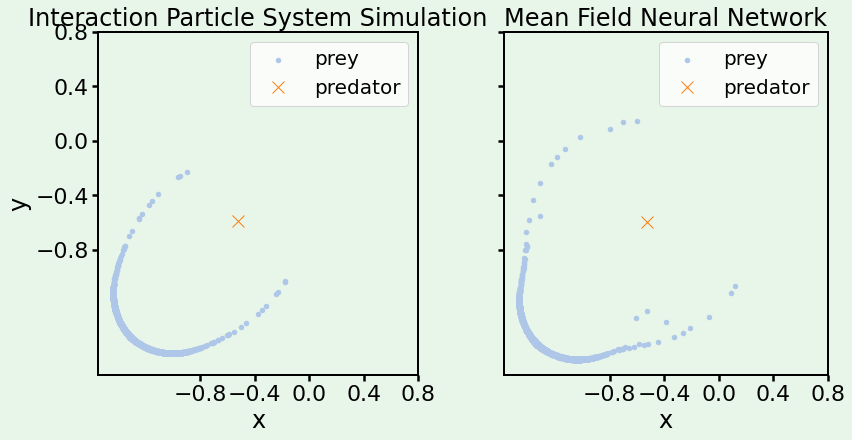

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.cm import tab20

# -----------------------------
# Load dataset A: (X, z)
# -----------------------------
dataA = np.load("../prey_predator2/TEST_DATA2/data/swarm_data_102.npz")
XA = dataA["X"]       # shape ~ (T_A, N, 2)
zA = dataA["z"]
print(zA.shape)

# unify zA to (T_A, 2)
if zA.ndim == 3 and zA.shape[1] == 1:
    zA = zA[:, 0, :]
zA = zA.reshape(len(zA), 2)
print(XA.shape)

TA = int(min(len(XA), len(zA)))
if TA == 0:
    raise ValueError(f"Dataset A has no frames: len(XA)={len(XA)}, len(zA)={len(zA)}")

# -----------------------------
# Load dataset B: (data_x, data_z)
# -----------------------------
XB = np.load("../prey_predator2/SIM3_2/data_102/x_save_102.npy")   # (T_B, N, 2)
ZB = np.load("../prey_predator2/SIM3_2/data_102/z_save_102.npy")   # (T_B, M, 2)
ZB = ZB.reshape(len(ZB), -1, 2)
print(ZB.shape, XB.shape)

TB = len(ZB)
if TB == 0:
    raise ValueError(f"Dataset B has no frames: len(XB)={len(XB)}, len(ZB)={len(ZB)}")

# -----------------------------
# Use common frame count
# -----------------------------
T = min(TA, TB)
print("Total frames:", T)
if T == 1:
    print("Only one frame available across datasets; will save a static figure.")

# -----------------------------
# Axis limits (panel-specific)
# -----------------------------
xminA = float(np.nanmin(XA[:T, ..., 0]))
xmaxA = float(np.nanmax(XA[:T, ..., 0]))
yminA = float(np.nanmin(XA[:T, ..., 1]))
ymaxA = float(np.nanmax(XA[:T, ..., 1]))
xminA = min(xminA, float(np.nanmin(zA[:T, 0])))
xmaxA = max(xmaxA, float(np.nanmax(zA[:T, 0])))
yminA = min(yminA, float(np.nanmin(zA[:T, 1])))
ymaxA = max(ymaxA, float(np.nanmax(zA[:T, 1])))
padA = 0.05 * max(xmaxA - xminA, ymaxA - yminA, 1e-9)

xminB = float(np.nanmin([XB[:T, ..., 0].min(), ZB[:T, ..., 0].min()]))
xmaxB = float(np.nanmax([XB[:T, ..., 0].max(), ZB[:T, ..., 0].max()]))
yminB = float(np.nanmin([XB[:T, ..., 1].min(), ZB[:T, ..., 1].min()]))
ymaxB = float(np.nanmax([XB[:T, ..., 1].max(), ZB[:T, ..., 1].max()]))
padB = 0.05 * max(xmaxB - xminB, ymaxB - yminB, 1e-9)

# -----------------------------
# Figure setup (shared y-axis)
# -----------------------------
fig, (axA, axB) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True, sharey=True)
f_size = 24
bg_color = "#E8F5E9"    # 背景颜色（你指定的颜色）
fig.patch.set_facecolor(bg_color)
axA.set_facecolor(bg_color)
axB.set_facecolor(bg_color)
for ax in (axA, axB):
    ax.set_facecolor(bg_color)
    for side in ['right','left','top','bottom']:
        ax.spines[side].set_linewidth(2)
    ax.xaxis.set_tick_params(which='major', size=6, width=2.5, direction='out', top=False)
    ax.xaxis.set_tick_params(which='minor', size=3, width=2, direction='out', top=False)
    ax.yaxis.set_tick_params(which='major', size=6, width=2.5, direction='out', right=False)
    ax.yaxis.set_tick_params(which='minor', size=3, width=2, direction='out', right=False)

# Colors
c_agents = tab20(1)
c_target = tab20(2)

# --- Panel A ---
XA0 = XA[0].reshape(-1, 2)
zA0 = zA[0]
scatA = axA.scatter(XA0[:, 0], XA0[:, 1], s=20, color=c_agents, label="prey")
(targetA,) = axA.plot([zA0[0]], [zA0[1]], "x", color=c_target, markersize=12, label="predator")

axA.set_xlim(xminA - padA, xmaxA + padA)
axA.set_ylim(yminA - padA, ymaxA + padA)
axA.set_aspect("equal")
axA.set_title("Interaction Particle System Simulation", fontsize=f_size)
axA.legend(loc="upper right", fontsize=f_size - 4)

# --- Panel B ---
XB0 = XB[0].reshape(-1, 2)
ZB0 = ZB[0].reshape(-1, 2)
scatB = axB.scatter(XB0[:, 0], XB0[:, 1], s=20, color=c_agents, label="prey")
(targetsB,) = axB.plot(ZB0[:, 0], ZB0[:, 1], "x", color=c_target, markersize=12, linestyle="None", label="predator")

axB.set_xlim(xminB - padB, xmaxB + padB)
axB.set_ylim(yminB - padB, ymaxB + padB)
axB.set_aspect("equal")
axB.set_title("Mean Field Neural Network", fontsize=f_size)
axB.legend(loc="upper right", fontsize=f_size - 4)

# Shared tick style
for ax in (axA, axB):
    ax.tick_params(labelsize=f_size - 2, width=2.5, length=6, direction="out")
    ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_xlabel("x", fontsize=f_size)
axA.set_ylabel("y", fontsize=f_size)

time_text = fig.suptitle("t = 0.00", fontsize=f_size, y=0.98)
time_text.set_animated(True)   # <-- important when blitting
# -----------------------------
# Update function (sync both)
# -----------------------------
def update(frame):
    # Panel A
    XA_f = XA[frame].reshape(-1, 2)
    zA_f = zA[frame]
    scatA.set_offsets(XA_f)
    targetA.set_data([zA_f[0]], [zA_f[1]])

    # Panel B
    XB_f = XB[frame].reshape(-1, 2)
    ZB_f = ZB[frame].reshape(-1, 2)
    scatB.set_offsets(XB_f)
    targetsB.set_data(ZB_f[:, 0], ZB_f[:, 1])
    time_text.set_text("t = {:.2f}".format(1e-2*frame))
    return scatA, targetA, scatB, targetsB, time_text

# -----------------------------
# Animate & save MP4
# -----------------------------
if T == 1:
    plt.savefig("prey_predator_case_2_snapshot_2_static.png", dpi=150, bbox_inches="tight")
else:
    ani = FuncAnimation(fig, update, frames=T, blit=True, interval=100, cache_frame_data=False)
    writer = FFMpegWriter(fps=20, codec="h264", bitrate=2000)
    ani.save("prey_predator_case_2_snapshot_2_animation.mp4", writer=writer, dpi=150)

plt.show()
